# AUS2200 Reflectivity Plot

In this notebook we will show you how to:

- Open data from the AUS2200 simulation raw output
- Extract the variable you need (reflectivity in this case)
- Plot this data onto a map of Australia

### Load the libraries

In [3]:
#Data libraries:
import xarray as xr
import numpy as np

# Plotting libraries:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Let's load Dask to make Xarray more efficient
import dask.distributed as dsk

# Start client
clnt = dsk.Client()
clnt

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40165 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40165/status,
Dashboard: /proxy/40165/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38061,Workers: 7
Dashboard: /proxy/40165/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:45769,Total threads: 1
Dashboard: /proxy/45861/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:32979,


- Dask speeds up analysis of the data, some of these files are quite big.
- You can find task on the toolbar on the left.
- Enter /proxy/8787/status (or whatever dashboard you are given) as the url.
- Using the 'Progress' window let's you see what tasks are happening when you run a command.

## Open the data into an Xarray dataset

Data available:

- day1 to day12
- 1hr: 
    - umnsa_cldrad
    - umnsa_mdl
    - umnsa_slv
    - umnsa_spec
- 3hr:
    - umnsaa_pvera000
    - umnsaa_pverb000
    - umnsaa_pverc000
    - umnsaa_pverd000

Let's open the 1 hourly data of 'umnsa_spec' file into Xarray, this contains the Reflectivity variable (and others too).

In [4]:
path = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/netcdf/day1/history/atm/netCDF/umnsa_spec_20220222T2300_1h.nc'

In [5]:
ds = xr.open_mfdataset(path, parallel=True, chunks = {'time': '200mb'})
# The parallel option allows xarray to run in parallel, might not be important when opening 1 file, 
# but if you're opening lots of files then this option would make things faster.
# It's good to set chunk size when opening data so Xarray/Dask is more efficient.

- We can print ds to see all the variables that are now available to us:

In [5]:
ds

<xarray.Dataset>
Dimensions:                   (time: 6, lat: 2120, lon: 2600, bnds: 2,
                               pseudo_level: 5, lon_0: 2600, lat_0: 2121,
                               time_0: 6)
Coordinates:
  * time                      (time) datetime64[ns] 2022-02-22T23:10:00 ... 2...
  * lat                       (lat) float64 -48.79 -48.77 ... -6.852 -6.832
  * lon                       (lon) float64 107.5 107.5 107.6 ... 159.0 159.0
    theta_level_height        float64 ...
    model_theta_level_number  int32 ...
    sigma_theta               float64 ...
  * pseudo_level              (pseudo_level) int32 1 2 3 4 5
  * lon_0                     (lon_0) float64 107.5 107.5 107.5 ... 159.0 159.0
    height                    float64 ...
  * lat_0                     (lat_0) float64 -48.8 -48.78 ... -6.842 -6.822
    height_0                  float64 ...
  * time_0                    (time_0) datetime64[ns] 2022-02-22T23:05:00.000...
Dimensions without coordinates: bnds
Data variables: (12/39)
    fld_s00i010               (time, lat, lon) float32 dask.array<chunksize=(6, 2120, 2600), meta=np.ndarray>
    latitude_longitude        int32 ...
    lat_bnds                  (lat, bnds) float64 dask.array<chunksize=(2120, 2), meta=np.ndarray>
    lon_bnds                  (lon, bnds) float64 dask.array<chunksize=(2600, 2), meta=np.ndarray>
    theta_level_height_bnds   (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    sigma_theta_bnds          (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    ...                        ...
    fld_s21i101               (time, lat, lon) float64 dask.array<chunksize=(4, 2120, 2600), meta=np.ndarray>
    fld_s21i104               (time_0, lat, lon) float32 dask.array<chunksize=(6, 2120, 2600), meta=np.ndarray>
    fld_s30i403               (time, lat, lon) float32 dask.array<chunksize=(6, 2120, 2600), meta=np.ndarray>
    fld_s30i404               (time, lat, lon) float32 dask.array<chunksize=(6, 2120, 2600), meta=np.ndarray>
    fld_s30i405               (time, lat, lon) float32 dask.array<chunksize=(6, 2120, 2600), meta=np.ndarray>
    fld_s30i406               (time, lat, lon) float32 dask.array<chunksize=(6, 2120, 2600), meta=np.ndarray>
Attributes:
    history:      File /g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/day1/20220...
    Conventions:  CF-1.6
    source:       Data from Met Office Unified Model
    um_version:   12.2

## Extract the Variable:

- Now let's select 'fld_s04i111', this is Reflectivity

In [6]:
reflect_1hr = ds.fld_s04i111

- Let's also extract the lat and lon values for plotting later.

In [7]:
lat = ds.lat
lon = ds.lon
lon2d, lat2d = np.meshgrid(lon, lat) # do we need this???

- Printing the reflect_1hr variable shows us what is inside.

In [11]:
reflect_1hr

<xarray.DataArray 'fld_s04i111' (time: 6, lat: 2120, lon: 2600)>
dask.array<open_dataset-bbf35bc2d6ff3cf058cf0fd8113ef4c3fld_s04i111, shape=(6, 2120, 2600), dtype=float32, chunksize=(6, 2120, 2600), chunktype=numpy.ndarray>
Coordinates:
  * time                      (time) datetime64[ns] 2022-02-22T23:10:00 ... 2...
  * lat                       (lat) float64 -48.79 -48.77 ... -6.852 -6.832
  * lon                       (lon) float64 107.5 107.5 107.6 ... 159.0 159.0
    theta_level_height        float64 ...
    model_theta_level_number  int32 ...
    sigma_theta               float64 ...
    height                    float64 ...
    height_0                  float64 ...
Attributes:
    long_name:        maximum_radar_reflectivity_in_the_grid_column_due_to_al...
    units:            dBZ
    um_stash_source:  m01s04i111
    grid_mapping:     latitude_longitude

## Plotting:

- Now we set up our plotting settings

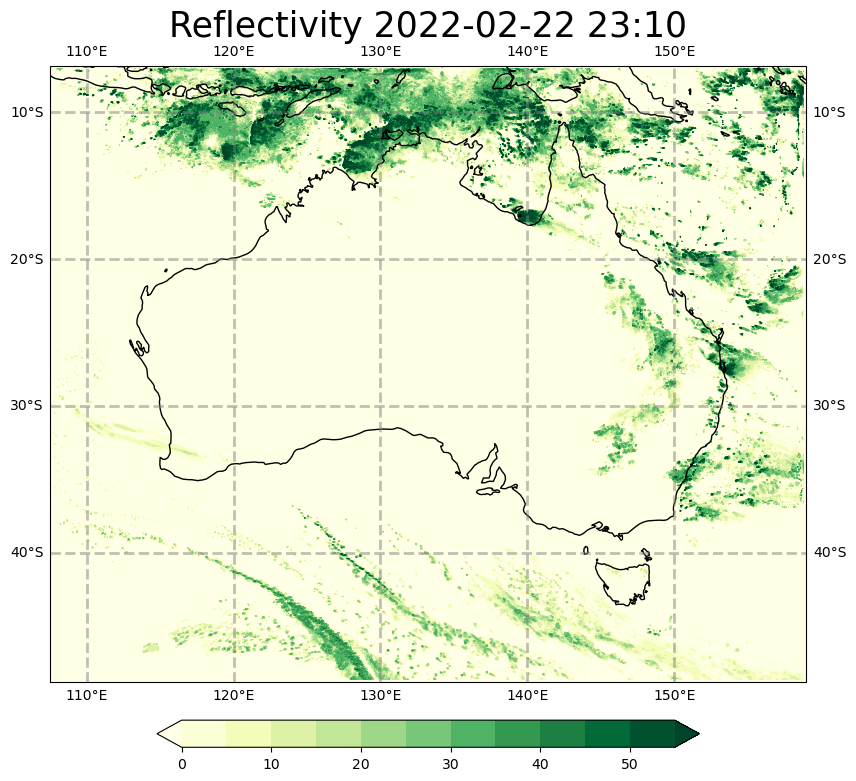

In [13]:
# Create an empty figure of a certain size
plt.figure(figsize=(10, 10))

# Set the projectioh map that we want to use and the colourmap
src = ccrs.PlateCarree()
ax = plt.axes(projection=src)
cmap=matplotlib.cm.get_cmap('YlGn')

# Create an array of values to change the colour by contour
levels = np.arange(0,60,5)

# Plot our data as a contour plot
ch = ax.contourf(lon2d, lat2d,  reflect_1hr.sel(time='2022-02-22T23:10:00.000000000', method='nearest'), levels=levels, cmap=cmap, extend='both')

# Set the title
title = 'Reflectivity 2022-02-22 23:10'
plt.title(title, size=25)

# Create gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Change the resolution of the coastlines
ax.coastlines('50m', linewidth=1)

# Create the colourbar and place it below our plot
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=plt.colorbar(ch,cax=cax,extend='both',**kw)